# SherLock

## Load Libraries

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import pickle

In [2]:
pd.set_option('display.max_columns', None)

"awk '{if ($2 > 1458086400000 && $2 < 1459468800000) print$0 }' Userpresentprobe.tsv > Filtered_Userpresentprobe.tsv"

## Load Data

This will cycle through all the data found in the Kaggle subset data, 'archive'.

### Functions Used

In [3]:
# Functions
def editTextFile(f):
    # Read in the file
    with open(f, 'r') as file:
        filedata = file.read()

    # Replace the target string
    filedata = filedata.replace('[msec],size','[msec];size')

    # Write the file out again
    with open('editTextFile.txt', 'w') as file:
        file.write(filedata)
        
def magVector(df,col1,col2,col3):
    # Calculate magnitude of vector - SQRT(X^2 + Y^2 + Z^2)
    return ((df[col1].pow(2) + df[col2].pow(2) + df[col3].pow(2)).pow(1/2))        

### Loading

In [4]:
filename = './Filtered_anon_Bluetooth.tsv'
header_list = ['userid','uuid','bluetooth_appearance','bluetooth_class','bluetooth_maddress',
               'bluetooth_mremotebrsf','bluetooth_mvaluenrec','bluetooth_mvaluewbs','bluetooth_name',
               'bluetooth_rssi','bluetooth_timestamp']
Bluetooth_tsv = pd.read_csv(filename, sep='\t', names=header_list, parse_dates=['bluetooth_timestamp'])
Bluetooth_tsv['uuid'] = (pd.to_datetime(Bluetooth_tsv['uuid'], unit='ms'))      # Convert to datatime
Bluetooth_tsv = Bluetooth_tsv.sort_values(by='uuid')                            # Unsorted, so sorting required
#Bluetooth_tsv = Bluetooth_tsv.set_index('uuid')
Bluetooth_tsv = Bluetooth_tsv.drop(columns=['bluetooth_mremotebrsf',
                                            'bluetooth_mvaluenrec',
                                            'bluetooth_mvaluewbs']) # Nan's and singular values, depricated
print(Bluetooth_tsv.shape)
Bluetooth_tsv.head(2)

(163537, 8)


,userid,uuid,bluetooth_appearance,bluetooth_class,bluetooth_maddress,bluetooth_name,bluetooth_rssi,bluetooth_timestamp
104936,bca57e81a1,2016-03-16 00:00:28.684,0.0,5898764,14617fbaa958d2b,dfbf1f088ebff75,-76,2016-03-16 02:00:01.522
146303,f68d404dec,2016-03-16 00:00:38.606,0.0,5898756,280c3ba0910e7eb,c49d34ab012e1c2,-75,2016-03-16 02:00:38.596


In [5]:
filename = './Filtered_Moriartyprobe.tsv'
header_list = ['userid','uuid','details','action','actionType','sessionType','Version','sessionID','behavior']
Moriarty_tsv = pd.read_csv(filename, sep='\t', names=header_list)
Moriarty_tsv['uuid'] = (pd.to_datetime(Moriarty_tsv['uuid'], unit='ms'))     # Convert to datatime
Moriarty_tsv = Moriarty_tsv.sort_values(by='uuid')                           # Unsorted, so sorting required
#Moriarty_tsv = Moriarty_tsv.set_index('uuid')
#print(Moriarty_tsv['userid'].unique())
print(Moriarty_tsv.shape)
Moriarty_tsv.head(2)

(101257, 9)


,userid,uuid,details,action,actionType,sessionType,Version,sessionID,behavior
17728,6e200090ee,2016-03-16 00:01:54.501,Begin photo theft from gallery(actor);Active-T...,Reading File(s),malicious,malicious,3.0,2002,NaN
17757,6e200090ee,2016-03-16 00:01:54.514,Searching for new photos to steal from the gal...,Reading File(s),malicious,malicious,3.0,2002,NaN


In [6]:
# Feature cleaning: drop odd states
#print(Moriarty_tsv['actionType'].unique())
#print(Moriarty_tsv[Moriarty_tsv['actionType'] == 'html'].shape)
#print(Moriarty_tsv[Moriarty_tsv['actionType'] == 'javascript'].shape)
#Moriarty_tsv = Moriarty_tsv.drop(Moriarty_tsv[(Moriarty_tsv['actionType'] == 'html') | 
#                                              (Moriarty_tsv['actionType'] == 'javascript')].index)
# Feature cleaning: drop v from version
#Moriarty_tsv['version'] = Moriarty_tsv['version'].astype(str).map(lambda x: x.lstrip('v'))

In [7]:
filename = './Filtered_Screenon.tsv'
header_list = ['userid','uuid','screenon','timestamp']
Screenon_tsv = pd.read_csv(filename, sep='\t', names=header_list, parse_dates=['timestamp'])
Screenon_tsv['uuid'] = (pd.to_datetime(Screenon_tsv['uuid'], unit='ms'))
Screenon_tsv = Screenon_tsv.sort_values(by='uuid')
#Screenon_tsv = Screenon_tsv.set_index('uuid')
Screenon_tsv['screenon'] = Screenon_tsv['screenon'].astype(int)                    # Original True:On / False:Off
#print(Screenon_tsv['userid'].unique())
print(Screenon_tsv.shape)
Screenon_tsv.head(2)

(131035, 4)


,userid,uuid,screenon,timestamp
51509,860550d355,2016-03-16 00:00:15.895,0,2016-03-16 02:00:15.892
1,0a50e09262,2016-03-16 00:00:17.035,0,2016-03-16 02:00:17.035


In [8]:
filename = './Filtered_a_anon_T1.tsv'
header_list = ['userid','uuid','version','googleplayloc_speed','googleplayloc_maccuracy',
               'googleplayloc_timestamp','celltower_cid','celltower_lac','celltower_psc',
               'celltower_timestamp','celltower_type','status_alarmvol','status_brightnessmode',
               'status_brightness_file','status_brightness_settings','status_dtmfvol','status_musicvol',
               'status_notificationvol','status_orientation','status_ringermode','status_ringtonevol',
               'status_systemvol','status_voicecallvol','status_timestamp',
               'location_spatio_5means','location_spatio_10means','location_spatio_25means',
               'location_spatio_50means','location_spatio_75means','location_spatio_100means',
               'location_spatioTemporal_day_5means','location_spatioTemporal_day_25means',
               'location_spatioTemporal_day_100means','location_spatioTemporal_week_5means',
               'location_spatioTemporal_week_25means','location_spatioTemporal_week_100means']
T1_tsv = pd.read_csv(filename, sep='\t', names=header_list, parse_dates=['googleplayloc_timestamp',
                                                                        'celltower_timestamp',
                                                                        'status_timestamp'])
T1_tsv['uuid'] = (pd.to_datetime(T1_tsv['uuid'], unit='ms'))
T1_tsv = T1_tsv.sort_values(by='uuid')
#T1_tsv = T1_tsv.set_index('uuid')
print(T1_tsv.shape)
T1_tsv.head(2)

(662195, 36)


,userid,uuid,version,googleplayloc_speed,googleplayloc_maccuracy,googleplayloc_timestamp,celltower_cid,celltower_lac,celltower_psc,celltower_timestamp,celltower_type,status_alarmvol,status_brightnessmode,status_brightness_file,status_brightness_settings,status_dtmfvol,status_musicvol,status_notificationvol,status_orientation,status_ringermode,status_ringtonevol,status_systemvol,status_voicecallvol,status_timestamp,location_spatio_5means,location_spatio_10means,location_spatio_25means,location_spatio_50means,location_spatio_75means,location_spatio_100means,location_spatioTemporal_day_5means,location_spatioTemporal_day_25means,location_spatioTemporal_day_100means,location_spatioTemporal_week_5means,location_spatioTemporal_week_25means,location_spatioTemporal_week_100means
0,0a50e09262,2016-03-16 00:00:01.840000000,2.1.3,1.200375,43.0,2016-03-16 01:59:33.909,99b8dbfcca059d7,5c91a35489d4236,5d0f8c37711cf91,2016-03-16 01:59:21.759,1.0,15.0,Auto,0.0,231.0,15.0,15.0,7.0,Portrait,Normal,15.0,7.0,4.0,2016-03-16 01:59:21.825,4.0,9.0,12.0,12.0,33.0,10.0,5.0,13.0,16.0,5.0,19.0,97.0
277103,8960d74df5,2016-03-16 00:00:08.257999872,2.1.3,0.000000,28.0,2016-03-16 01:59:57.513,35cfbd7502354db,1769ada0735a635,f281a2d2f29ac2e,2016-03-16 01:59:55.371,1.0,5.0,Auto,0.0,136.0,0.0,4.0,0.0,Portrait,Normal,0.0,0.0,5.0,2016-03-16 01:59:55.387,5.0,5.0,10.0,44.0,21.0,67.0,5.0,22.0,8.0,3.0,16.0,82.0


In [9]:
filename = './Filtered_T4_filtered.tsv'
header_list = ['userid','uuid','version','CpuHertz','CPU_0','CPU_1','CPU_2','CPU_3','Total_CPU',
               'TotalMemory_freeSize','TotalMemory_max_size','TotalMemory_total_size','TotalMemory_used_size',
               'Traffic_MobileRxBytes','Traffic_MobileRxPackets','Traffic_MobileTxBytes',
               'Traffic_MobileTxPackets','Traffic_TotalRxBytes','Traffic_TotalRxPackets','Traffic_TotalTxBytes',
               'Traffic_TotalTxPackets','Traffic_TotalWifiRxBytes','Traffic_TotalWifiRxPackets',
               'Traffic_TotalWifiTxBytes','Traffic_TotalWifiTxPackets','Traffic_timestamp','Battery_charge_type',
               'Battery_current_avg','Battery_health','Battery_icon_small','Battery_invalid_charger',
               'Battery_level','Battery_online','Battery_plugged','Battery_present','Battery_scale',
               'Battery_status','Battery_technology','Battery_temperature','Battery_timestamp','Battery_voltage',
               'MemTotal','MemFree','Buffers','Cached','SwapCached','Active','Inactive','Active_anon',
               'Inactive_anon','Active_file','Inactive_file','Unevictable','Mlocked','HighTotal','HighFree',
               'LowTotal','LowFree','SwapTotal','SwapFree','Dirty','Writeback','AnonPages','Mapped',
               'Shmem','Slab','SReclaimable','SUnreclaim','KernelStack','PageTables','CommitLimit','Committed_AS',
               'VmallocTotal','VmallocUsed','VmallocChunk','msmgpio_cpu0','msmgpio_sum_cpu123','wcd9xxx_cpu0',
               'wcd9xxx_sum_cpu123','pn547_cpu0','pn547_sum_cpu123','cypress_touchkey_cpu0',
               'cypress_touchkey_sum_cpu123','synaptics_rmi4_i2c_cpu0','synaptics_rmi4_i2c_sum_cpu123',
               'sec_headset_detect_cpu0','sec_headset_detect_sum_cpu123','flip_cover_cpu0','flip_cover_sum_cpu123',
               'home_key_cpu0','home_key_sum_cpu123','volume_down_cpu0','volume_down_sum_cpu123','volume_up_cpu0',
               'volume_up_sum_cpu123','companion_cpu0','companion_sum_cpu123','SLIMBUS_cpu0','SLIMBUS_sum_cpu123',
               'function_call_interrupts_cpu0','function_call_interrupts_sum_cpu123','cpu123_intr_prs','tot_user',
               'tot_nice','tot_system','tot_idle','tot_iowait','tot_irq','tot_softirq','ctxt','btime','processes',
               'procs_running','procs_blocked','connectedWifi_SSID','connectedWifi_Level', '117','118','119',
              '120', '121','122','123','124','125','126','127','128','129','130']
T4_tsv = pd.read_csv(filename, sep='\t', names=header_list, parse_dates=['Traffic_timestamp'])
T4_tsv['uuid'] = (pd.to_datetime(T4_tsv['uuid'], unit='ms'))
T4_tsv = T4_tsv.drop(columns=['Battery_charge_type','Battery_current_avg','Battery_health','Battery_icon_small',
                              'Battery_invalid_charger','Battery_level','Battery_online','Battery_plugged',
                              'Battery_present','Battery_scale','Battery_status','Battery_technology',
                              'Battery_temperature','Battery_timestamp','Battery_voltage','MemTotal','MemFree',
                              'Buffers','Cached','SwapCached','Active','Inactive','Active_anon','Inactive_anon',
                              'Active_file','Inactive_file','Unevictable','Mlocked','HighTotal','HighFree',
                              'LowTotal','LowFree','SwapTotal','SwapFree','Dirty','Writeback','AnonPages','Mapped',
                              'Shmem','Slab','SReclaimable','SUnreclaim','KernelStack','PageTables','CommitLimit',
                              'Committed_AS','VmallocTotal','VmallocUsed','VmallocChunk','msmgpio_cpu0',
                              'msmgpio_sum_cpu123','wcd9xxx_cpu0','wcd9xxx_sum_cpu123','pn547_cpu0',
                              'pn547_sum_cpu123','cypress_touchkey_cpu0','cypress_touchkey_sum_cpu123',
                              'synaptics_rmi4_i2c_cpu0','synaptics_rmi4_i2c_sum_cpu123','sec_headset_detect_cpu0',
                              'sec_headset_detect_sum_cpu123','flip_cover_cpu0','flip_cover_sum_cpu123',
                              'home_key_cpu0','home_key_sum_cpu123','volume_down_cpu0','volume_down_sum_cpu123',
                              'volume_up_cpu0','volume_up_sum_cpu123','companion_cpu0','companion_sum_cpu123',
                              'SLIMBUS_cpu0','SLIMBUS_sum_cpu123','function_call_interrupts_cpu0',
                              'function_call_interrupts_sum_cpu123','cpu123_intr_prs','tot_user','tot_nice',
                              'tot_system','tot_idle','tot_iowait','tot_irq','tot_softirq','ctxt','btime',
                              'processes','procs_running','procs_blocked','connectedWifi_SSID',
                              'connectedWifi_Level','117','118','119','120', '121','122','123','124','125','126',
                              '127','128','129','130'])
T4_tsv = T4_tsv.sort_values(by='uuid')
#T4_tsv = T4_tsv.set_index('uuid')
print(T4_tsv.shape)
T4_tsv.head(2)

/Users/kent/opt/anaconda3/envs/sherlock/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,34,37,39) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(2359469, 26)


,userid,uuid,version,CpuHertz,CPU_0,CPU_1,CPU_2,CPU_3,Total_CPU,TotalMemory_freeSize,TotalMemory_max_size,TotalMemory_total_size,TotalMemory_used_size,Traffic_MobileRxBytes,Traffic_MobileRxPackets,Traffic_MobileTxBytes,Traffic_MobileTxPackets,Traffic_TotalRxBytes,Traffic_TotalRxPackets,Traffic_TotalTxBytes,Traffic_TotalTxPackets,Traffic_TotalWifiRxBytes,Traffic_TotalWifiRxPackets,Traffic_TotalWifiTxBytes,Traffic_TotalWifiTxPackets,Traffic_timestamp
937807,3e9c54bce7,2016-03-16 00:00:00.861,2.1.4,2.4 GHz,0.000000,0.00000,0.0,0.000000,0.000000,4732148.0,134217728.0,51235530.0,46503382.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-03-16 02:00:00.768
12,0a50e09262,2016-03-16 00:00:01.564,2.1.3,1.7 GHz,44.444447,28.57143,0.0,17.647058,22.665733,1488782.0,134217728.0,44722776.0,43233994.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-03-16 02:00:01.480


In [10]:
#T4_dropList = T4_tsv.columns[T4_tsv.isna().any()].tolist()
#T4_NaNCounts = T4_tsv[T4_tsv.columns[T4_tsv.isnull().any()]].isnull().sum().sort_values(ascending=True)

In [11]:
filename = './Filtered_Userpresentprobe.tsv'
header_list = ['userid', 'uuid', 'timestamp']
Userpresentprobe_tsv = pd.read_csv(filename, sep='\t', names=header_list, parse_dates=['timestamp'])
Userpresentprobe_tsv['uuid'] = (pd.to_datetime(Userpresentprobe_tsv['uuid'], unit='ms'))
Userpresentprobe_tsv = Userpresentprobe_tsv.sort_values(by='uuid')
#Userpresentprobe_tsv = Userpresentprobe_tsv.set_index('uuid')
Userpresentprobe_tsv['UP_status'] = 1                    # Added column as a marker
print(Userpresentprobe_tsv.shape)
Userpresentprobe_tsv.head(2)

(37034, 4)


,userid,uuid,timestamp,UP_status
34518,fd2db8f0be,2016-03-16 00:24:50.086,2016-03-16 02:24:50.078,1
32801,f68d404dec,2016-03-16 00:36:21.803,2016-03-16 02:36:21.793,1


In [12]:
filename = './Filtered_anon_Wifi.lineendings.tsv'
header_list = ['userid', 'uuid', 'ssid','capabilities','freq','level']
Wifi_tsv = pd.read_csv(filename, sep='\t', names=header_list)
Wifi_tsv['uuid'] = (pd.to_datetime(Wifi_tsv['uuid'], unit='ms'))
Wifi_tsv = Wifi_tsv.sort_values(by='uuid')
#Wifi_tsv = Wifi_tsv.set_index('uuid')
print(Wifi_tsv.shape)
Wifi_tsv.head(2)

(2355475, 6)


,userid,uuid,ssid,capabilities,freq,level
1165746,8960d74df5,2016-03-16 00:00:08.258,cf0a8cd77830521,[WPA-PSK-CCMP+TKIP][WPA2-PSK-CCMP+TKIP][ESS],2437,NaN
1165742,8960d74df5,2016-03-16 00:00:08.258,09eae5beab19574,[ESS],5320,NaN


## EDA

#### Moriarty exploration

In [13]:
print('Moriarty Sessions: ', Moriarty_tsv.sessionType.count())
print(Moriarty_tsv.groupby('sessionType')['uuid'].nunique())
Moriarty_tsv.groupby('actionType')['uuid'].nunique()
# should drop the non-benign/malicious....

Moriarty Sessions:  101257
sessionType
benign        1100
malicious    99874
Name: uuid, dtype: int64


actionType
benign          483
malicious    100491
Name: uuid, dtype: int64

In [14]:
print(Moriarty_tsv['sessionID'].value_counts().sort_values())
#Moriarty_tsv['sessionID'].unique()
#Moriarty_tsv.groupby(['sessionID', 'sessionType']).count()

#Moriarty_tsv[Moriarty_tsv['sessionID'] == 15]
Moriarty_tsv[Moriarty_tsv['sessionID'].astype(str) == 'v3.0']  # FAILS

18          1
30          1
32          1
2009        4
1017        4
28          4
8           5
2           5
1013        5
24          6
16          6
10          8
1019        8
4          12
22         15
14         15
12         17
1          19
20         33
6          40
1012      133
1020      169
9         199
1014      203
33        465
35        478
1016      578
0         932
3        1044
2006     1208
29       1382
2012     1439
2014     1490
31       1630
2002     1806
2000     1885
2004     2261
2008     2278
23       2720
1022     3149
27       3158
11       3372
25       3463
2010     3507
7        6328
13       6782
21       9672
17      11444
19      11748
15      16125
Name: sessionID, dtype: int64


,userid,uuid,details,action,actionType,sessionType,Version,sessionID,behavior


In [15]:
#pd.set_option('display.max_rows', 500)
Moriarty_tsv.head(10)

,userid,uuid,details,action,actionType,sessionType,Version,sessionID,behavior
17728,6e200090ee,2016-03-16 00:01:54.501,Begin photo theft from gallery(actor);Active-T...,Reading File(s),malicious,malicious,3.0,2002,NaN
17757,6e200090ee,2016-03-16 00:01:54.514,Searching for new photos to steal from the gal...,Reading File(s),malicious,malicious,3.0,2002,NaN
17523,6e200090ee,2016-03-16 00:01:54.525,Didn't found a new photo(actor);Active-Thief,Reading File(s),malicious,malicious,3.0,2002,NaN
21825,6fec24656a,2016-03-16 00:03:22.267,Begin photo theft from gallery(actor);Active-T...,Reading File(s),malicious,malicious,3.0,3,NaN
21836,6fec24656a,2016-03-16 00:03:22.283,Searching for new photos to steal from the gal...,Reading File(s),malicious,malicious,3.0,3,NaN
21829,6fec24656a,2016-03-16 00:03:22.315,Didn't found a new photo(actor);Active-Thief,Reading File(s),malicious,malicious,3.0,3,NaN
90171,e22b9f3772,2016-03-16 00:03:48.234,searching for wifi,Probing for WiFi access,malicious,malicious,3.0,19,NaN
90529,e22b9f3772,2016-03-16 00:03:48.239,Response: Wifi available,Probing for WiFi access,malicious,malicious,3.0,19,NaN
90293,e22b9f3772,2016-03-16 00:03:48.263,Begin photo/video theft from gallery(actor);Ba...,Reading File(s),malicious,malicious,3.0,19,NaN
90051,e22b9f3772,2016-03-16 00:03:48.269,Searching for new photos/videos to steal from ...,Reading File(s),malicious,malicious,3.0,19,NaN


In [16]:
pd.set_option('display.max_rows', 15)

Benign actions

In [17]:
Moriarty_tsv[Moriarty_tsv["actionType"] == "benign"][["details", "action"]]

,details,action
97855,Start of stats reading service,Service Launch
67551,Start of stats reading service,Service Launch
21955,App entered onCreate(),App Mode Change
22018,App entered onResume(),App Mode Change
21975,App entered onPause(),App Mode Change
...,...,...
61725,App entered onCreate(),App Mode Change
61724,App entered onResume(),App Mode Change
61719,App entered onPause(),App Mode Change
9623,Start of stats reading service,Service Launch


Malicious

In [18]:
Moriarty_tsv[Moriarty_tsv["actionType"] == "malicious"][["details", "action"]]

,details,action
17728,Begin photo theft from gallery(actor);Active-T...,Reading File(s)
17757,Searching for new photos to steal from the gal...,Reading File(s)
17523,Didn't found a new photo(actor);Active-Thief,Reading File(s)
21825,Begin photo theft from gallery(actor);Active-T...,Reading File(s)
21836,Searching for new photos to steal from the gal...,Reading File(s)
...,...,...
9632,Begin photo theft from gallery(actor);Active-T...,Reading File(s)
9660,Searching for new photos to steal from the gal...,Reading File(s)
9662,Didn't found a new photo(actor);Active-Thief,Reading File(s)
9650,searching for wifi,Probing for WiFi access


In [19]:
                                                  #NEED TO SUBDIVIDE BY VERSION
mSessList = Moriarty_tsv['sessionID'].unique()
minT = []
maxT = []

for i, ses in enumerate(mSessList):
    x = Moriarty_tsv[Moriarty_tsv['sessionID'] == ses]['uuid'].min()
    y = Moriarty_tsv[Moriarty_tsv['sessionID'] == ses]['uuid'].max()
    minT.append(x)
    maxT.append(y)

MoriartySessions = pd.concat([pd.Series(mSessList,name='sessionID'),
                              pd.Series(minT,name='minT'),
                              pd.Series(maxT,name='maxT')], axis=1)
MoriartySessions['Duration'] = MoriartySessions['maxT'] - MoriartySessions['minT']
MoriartySessions

,sessionID,minT,maxT,Duration
0,2002,2016-03-16 00:01:54.501,2016-03-17 10:00:10.224,1 days 09:58:15.723000
1,3,2016-03-16 00:03:22.267,2016-03-18 05:14:51.256,2 days 05:11:28.989000
2,19,2016-03-16 00:03:48.234,2016-03-31 08:58:11.063,15 days 08:54:22.829000
3,2008,2016-03-16 01:14:40.794,2016-03-29 08:57:41.357,13 days 07:43:00.563000
4,11,2016-03-16 02:06:47.710,2016-03-27 08:52:22.110,11 days 06:45:34.400000
...,...,...,...,...
45,1022,2016-03-30 11:07:35.583,2016-03-31 10:57:35.454,0 days 23:49:59.871000
46,35,2016-03-30 11:51:44.088,2016-03-31 08:34:38.343,0 days 20:42:54.255000
47,2014,2016-03-30 16:16:21.252,2016-03-31 14:05:25.215,0 days 21:49:03.963000
48,30,2016-03-30 19:18:18.379,2016-03-30 19:18:18.379,0 days 00:00:00


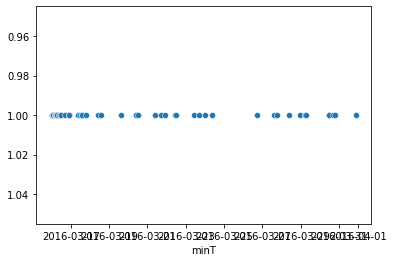

In [20]:
# Time series plots of moriarty
sns.scatterplot(data=MoriartySessions, x='minT', y=1)
plt.gca().invert_yaxis()
plt.show()

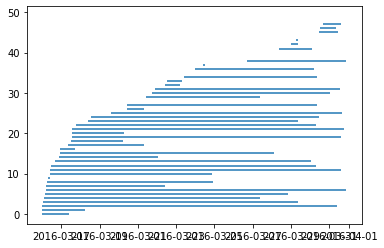

In [21]:
# Duration of moriarty
#sns.scatterplot(data=MoriartySessions, x='sessionID', y='Duration')
#plt.gca().invert_yaxis()
#plt.show()
# need to find different x axis, time

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dt

fig = plt.figure()
ax = fig.add_subplot(111)
ax = ax.xaxis_date()
ax = plt.hlines(MoriartySessions.index, dt.date2num(MoriartySessions.minT), dt.date2num(MoriartySessions.maxT))

In [22]:
# plot intra-session moriarty behavorior

## Feature engineering of Moriarty

In [23]:
binary = {'benign': 0, 'malicious': 1}
Moriarty_tsv = Moriarty_tsv.replace({'actionType':binary})
Moriarty_tsv = Moriarty_tsv.replace({'sessionType':binary})
Moriarty_tsv

,userid,uuid,details,action,actionType,sessionType,Version,sessionID,behavior
17728,6e200090ee,2016-03-16 00:01:54.501,Begin photo theft from gallery(actor);Active-T...,Reading File(s),1,1,3.0,2002,NaN
17757,6e200090ee,2016-03-16 00:01:54.514,Searching for new photos to steal from the gal...,Reading File(s),1,1,3.0,2002,NaN
17523,6e200090ee,2016-03-16 00:01:54.525,Didn't found a new photo(actor);Active-Thief,Reading File(s),1,1,3.0,2002,NaN
21825,6fec24656a,2016-03-16 00:03:22.267,Begin photo theft from gallery(actor);Active-T...,Reading File(s),1,1,3.0,3,NaN
21836,6fec24656a,2016-03-16 00:03:22.283,Searching for new photos to steal from the gal...,Reading File(s),1,1,3.0,3,NaN
...,...,...,...,...,...,...,...,...,...
9660,56d7a3b146,2016-03-31 21:10:41.323,Searching for new photos to steal from the gal...,Reading File(s),1,1,3.0,2000,NaN
9662,56d7a3b146,2016-03-31 21:10:41.324,Didn't found a new photo(actor);Active-Thief,Reading File(s),1,1,3.0,2000,NaN
9650,56d7a3b146,2016-03-31 21:11:04.602,searching for wifi,Probing for WiFi access,1,1,3.0,2000,NaN
9645,56d7a3b146,2016-03-31 21:11:23.881,searching for wifi,Probing for WiFi access,1,1,3.0,2000,NaN


### Sensors

In [24]:
#T2['magAccel'] = magVector(T2,'AccelerometerStat_x_MIDDLE_SAMPLE',
#                           'AccelerometerStat_y_MIDDLE_SAMPLE',
#                           'AccelerometerStat_z_MIDDLE_SAMPLE')
#T2['magMag'] = magVector(T2,'MagneticField_x_MIDDLE_SAMPLE',
#                           'MagneticField_y_MIDDLE_SAMPLE',
#                           'MagneticField_z_MIDDLE_SAMPLE')
#T2.head(3)

In [25]:
# plots of sensors in time...

## Extract Moriarty across datasets

In [26]:
pd.Series(Moriarty_tsv.uuid.values,index=Moriarty_tsv.uuid.values).to_dict()

{Timestamp('2016-03-16 00:01:54.501000'): Timestamp('2016-03-16 00:01:54.501000'),
 Timestamp('2016-03-16 00:01:54.514000'): Timestamp('2016-03-16 00:01:54.514000'),
 Timestamp('2016-03-16 00:01:54.525000'): Timestamp('2016-03-16 00:01:54.525000'),
 Timestamp('2016-03-16 00:03:22.267000'): Timestamp('2016-03-16 00:03:22.267000'),
 Timestamp('2016-03-16 00:03:22.283000'): Timestamp('2016-03-16 00:03:22.283000'),
 Timestamp('2016-03-16 00:03:22.315000'): Timestamp('2016-03-16 00:03:22.315000'),
 Timestamp('2016-03-16 00:03:48.234000'): Timestamp('2016-03-16 00:03:48.234000'),
 Timestamp('2016-03-16 00:03:48.239000'): Timestamp('2016-03-16 00:03:48.239000'),
 Timestamp('2016-03-16 00:03:48.263000'): Timestamp('2016-03-16 00:03:48.263000'),
 Timestamp('2016-03-16 00:03:48.269000'): Timestamp('2016-03-16 00:03:48.269000'),
 Timestamp('2016-03-16 00:03:49.476000'): Timestamp('2016-03-16 00:03:49.476000'),
 Timestamp('2016-03-16 00:03:49.480000'): Timestamp('2016-03-16 00:03:49.480000'),
 Tim

In [27]:
# TSV
print('Bluetooth_tsv.shape ', Bluetooth_tsv.shape)
print('Moriarty_tsv.shape  ', Moriarty_tsv.shape)
print('Screenon_tsv.shape  ', Screenon_tsv.shape)
print('T1_tsv.shape        ', T1_tsv.shape)
print('T4_tsv              ', T4_tsv.shape)
print('Userpresentprobe_tsv',Userpresentprobe_tsv.shape)
print('Wifi_tsv            ',Wifi_tsv.shape)

print('M+Blue     ',pd.merge(left=Moriarty_tsv, right=Bluetooth_tsv, left_on='uuid', right_on='uuid').shape)
print('M+Screen   ',pd.merge(left=Moriarty_tsv, right=Screenon_tsv,  left_on='uuid', right_on='uuid').shape)
print('M+T1       ',pd.merge(left=Moriarty_tsv, right=T1_tsv,        left_on='uuid', right_on='uuid').shape)
print('M+T4       ',pd.merge(left=Moriarty_tsv, right=T4_tsv,        left_on='uuid', right_on='uuid').shape)
print('M+User     ',pd.merge(left=Moriarty_tsv, right=Userpresentprobe_tsv, left_on='uuid', right_on='uuid').shape)
print('M+Wifi     ',pd.merge(left=Moriarty_tsv, right=Wifi_tsv, left_on='uuid', right_on='uuid').shape)

print('T1+Screen   ',pd.merge(left=T1_tsv, right=T4_tsv,  left_on='uuid', right_on='uuid').shape)

#Moriarty_tsv['uuid'].dt.round('1s').head()
#T4_tsv['uuid'].dt.round('1s').head()
#print('M+T4 ROUNDED     ',pd.merge(left=Moriarty_tsv, right=Bluetooth_tsv, left_on='uuidROUND', right_on='uuidROUND').shape)

#pd.merge(left=Moriarty_tsv, right=Screenon_tsv, how='outer', left_on='uuid', right_on='uuid').head(20)


#print(pd.merge(left=Moriarty_tsv, right=Userpresentprobe_tsv, left_on='uuid', right_on='uuid').shape)
#merged_left = pd.merge(left=Moriarty_tsv, right=Screenon_tsv, how='left', left_on='uuid', right_on='uuid')
#merged_left.tail(200)

Bluetooth_tsv.shape  (163537, 8)
Moriarty_tsv.shape   (101257, 9)
Screenon_tsv.shape   (131035, 4)
T1_tsv.shape         (662195, 36)
T4_tsv               (2359469, 26)
Userpresentprobe_tsv (37034, 4)
Wifi_tsv             (2355475, 6)
M+Blue      (20, 16)
M+Screen    (14, 12)
M+T1        (17, 44)
M+T4        (208, 34)
M+User      (3, 12)
M+Wifi      (198, 14)
T1+Screen    (290, 61)


### Screen On

In [28]:
# Combine T4 with append with Moriarty 
Merged = T4_tsv.append(Moriarty_tsv, sort=True)
Merged = Merged.sort_values(by='uuid')

# Pad downwards into T4
Merged[['actionType', 'sessionType']] = Merged[['actionType', 'sessionType']].fillna(method='pad', limit=5)  #5 rows only

# Delete everything that is not Moriarty or within ____ samples from Moriarty
Merged = Merged.dropna(subset=['sessionType'])
######################################################
# Combine Merged with append with Screenon
Merged = Merged.append(Screenon_tsv, sort=True)
Merged = Merged.sort_values(by='uuid')
print(Merged.shape)

# Pad downwards into T4
Merged[['actionType', 'sessionType']] = Merged[['actionType', 'sessionType']].fillna(method='pad', limit=5)  #5 rows only

# Delete everything that is not Moriarty or within ____ samples from Moriarty
Merged = Merged.dropna(subset=['sessionType'])
######################################################
# Combine Merged with append with T1
Merged = Merged.append(T1_tsv, sort=True)
Merged = Merged.sort_values(by='uuid')
print(Merged.shape)

# Pad downwards into T4
Merged[['actionType', 'sessionType']] = Merged[['actionType', 'sessionType']].fillna(method='pad', limit=5)  #5 rows only

# Delete everything that is not Moriarty or within ____ samples from Moriarty
Merged = Merged.dropna(subset=['sessionType'])
######################################################
# Combine Merged with append with Bluetooth
Merged = Merged.append(Bluetooth_tsv, sort=True)
Merged = Merged.sort_values(by='uuid')
print(Merged.shape)

# Pad downwards into T4
Merged[['actionType', 'sessionType']] = Merged[['actionType', 'sessionType']].fillna(method='pad', limit=5)  #5 rows only

# Delete everything that is not Moriarty or within ____ samples from Moriarty
Merged = Merged.dropna(subset=['sessionType'])
######################################################
# Combine Merged with append with Userpresentprobe
Merged = Merged.append(Userpresentprobe_tsv, sort=True)
Merged = Merged.sort_values(by='uuid')
print(Merged.shape)

# Pad downwards into T4
Merged[['actionType', 'sessionType']] = Merged[['actionType', 'sessionType']].fillna(method='pad', limit=5)  #5 rows only

# Delete everything that is not Moriarty or within ____ samples from Moriarty
Merged = Merged.dropna(subset=['sessionType'])
######################################################
# Combine Merged with append with Wifi
Merged = Merged.append(Wifi_tsv, sort=True)
Merged = Merged.sort_values(by='uuid')
print(Merged.shape)

# Pad downwards into T4
Merged[['actionType', 'sessionType']] = Merged[['actionType', 'sessionType']].fillna(method='pad', limit=5)  #5 rows only

# Delete everything that is not Moriarty or within ____ samples from Moriarty
Merged = Merged.dropna(subset=['sessionType'])
Merged.head(20)

(376717, 35)
(971524, 68)
(725265, 74)
(714328, 75)
(3066311, 79)


,CPU_0,CPU_1,CPU_2,CPU_3,CpuHertz,TotalMemory_freeSize,TotalMemory_max_size,TotalMemory_total_size,TotalMemory_used_size,Total_CPU,Traffic_MobileRxBytes,Traffic_MobileRxPackets,Traffic_MobileTxBytes,Traffic_MobileTxPackets,Traffic_TotalRxBytes,Traffic_TotalRxPackets,Traffic_TotalTxBytes,Traffic_TotalTxPackets,Traffic_TotalWifiRxBytes,Traffic_TotalWifiRxPackets,Traffic_TotalWifiTxBytes,Traffic_TotalWifiTxPackets,Traffic_timestamp,UP_status,Version,action,actionType,behavior,bluetooth_appearance,bluetooth_class,bluetooth_maddress,bluetooth_name,bluetooth_rssi,bluetooth_timestamp,capabilities,celltower_cid,celltower_lac,celltower_psc,celltower_timestamp,celltower_type,details,freq,googleplayloc_maccuracy,googleplayloc_speed,googleplayloc_timestamp,level,location_spatioTemporal_day_100means,location_spatioTemporal_day_25means,location_spatioTemporal_day_5means,location_spatioTemporal_week_100means,location_spatioTemporal_week_25means,location_spatioTemporal_week_5means,location_spatio_100means,location_spatio_10means,location_spatio_25means,location_spatio_50means,location_spatio_5means,location_spatio_75means,screenon,sessionID,sessionType,ssid,status_alarmvol,status_brightness_file,status_brightness_settings,status_brightnessmode,status_dtmfvol,status_musicvol,status_notificationvol,status_orientation,status_ringermode,status_ringtonevol,status_systemvol,status_timestamp,status_voicecallvol,timestamp,userid,uuid,version
17728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,3.0,Reading File(s),1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,Begin photo theft from gallery(actor);Active-T...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,6e200090ee,2016-03-16 00:01:54.501000000,NaN
17757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,3.0,Reading File(s),1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,Searching for new photos to steal from the gal...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,6e200090ee,2016-03-16 00:01:54.514000000,NaN
17523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,3.0,Reading File(s),1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,Didn't found a new photo(actor);Active-Thief,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,6e200090ee,2016-03-16 00:01:54.525000000,NaN
1018995,30.434782,100.0,100.0,100.0,1.1 GHz,8605144.0,134217728.0,29241344.0,20636200.0,82.608696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-03-16 02:01:54.426,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,55153967c4,2016-03-16 00:01:54.728000000,2.1.4
2226651,0.000000,40.0,0.0,0.0,2.4 GHz,13085964.0,134217728.0,34970292.0,21884328.0,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-03-16 02:01:54.936,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,65f42fb278,2016-03-16 00:01:55.059000000,2.1.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [29]:
print('Moriarty Sessions: ', Merged.sessionType.count())
print(Merged.groupby('sessionType')['uuid'].nunique())
Merged.groupby('actionType')['uuid'].nunique()
# should drop the non-benign/malicious....

Moriarty Sessions:  1631914
sessionType
0.0     10690
1.0    859088
Name: uuid, dtype: int64


actionType
0.0      6384
1.0    863394
Name: uuid, dtype: int64

In [30]:
#Merge #1
Merged = Screenon_tsv.append(Moriarty_tsv, sort=True)
#Merged = Merged.sort_index()
Merged = Merged.sort_values(by='uuid')
print(Merged.shape)

# Pad downwards into Moriarty
Merged[['version', 'timestamp', 'screenon']] = Merged[['version', 'timestamp', 'screenon']].fillna(method="pad")
pd.set_option('display.max_rows', 500)

# Delete Screen...
Merged = Merged.dropna(subset=['sessionType'])
Merged.head(3)

(232292, 11)


KeyError: "['version'] not in index"

In [ ]:
#Merge #2
Merged2 = Merged.append(T4_tsv, sort=True)
#Merged = Merged.sort_index()
Merged2 = Merged2.sort_values(by='uuid')
print(Merged2.shape)

# Pad downwards into Moriarty
header_list2 = ['userid','uuid','version','CpuHertz','CPU_0','CPU_1','CPU_2','CPU_3','Total_CPU',
               'TotalMemory_freeSize','TotalMemory_max_size','TotalMemory_total_size','TotalMemory_used_size',
               'Traffic_MobileRxBytes','Traffic_MobileRxPackets','Traffic_MobileTxBytes',
               'Traffic_MobileTxPackets','Traffic_TotalRxBytes','Traffic_TotalRxPackets','Traffic_TotalTxBytes',
               'Traffic_TotalTxPackets','Traffic_TotalWifiRxBytes','Traffic_TotalWifiRxPackets',
               'Traffic_TotalWifiTxBytes','Traffic_TotalWifiTxPackets','Traffic_timestamp']
Merged2[header_list2] = Merged2[header_list2].fillna(method="pad")
#pd.set_option('display.max_rows', 500)

# Delete T4...
Merged2 = Merged2.dropna(subset=['sessionType'])
Merged2.head(3)

In [ ]:
filteredMerged = pd.DataFrame()

for index, row in MoriartySessions.iterrows():
    data = Merged[(Merged['UUID'] > row['minT']) & (Merged['UUID'] < row['maxT'])]
    filteredMerged = filteredMerged.append(data, ignore_index=True)
    
filteredMerged[['SessionID', 'SessionType', 'Version']] = filteredMerged[['SessionID', 'SessionType', 'Version']].fillna(method="pad")

In [ ]:
# next steps - integer encode unique - aggregate Success...
filteredMerged['Details'].unique()

In [ ]:
#unit type action type
#malicious vs benigin

In [ ]:
###### predict is screen on from magnitude

In [ ]:
#### predict screen on moriarty...

In [ ]:
sns.distplot(T2['AccelerometerStat_x_MIDDLE_SAMPLE'])
plt.title('Histogram: AccelerometerStat_x_MIDDLE_SAMPLE')
plt.xlabel('_something_')
f = plt.gcf()
f.set_size_inches(6,3)
plt.show()

### Goofy stuff

In [ ]:
t2_accelero = T2[['AccelerometerStat_x_MIDDLE_SAMPLE', 
                  'AccelerometerStat_y_MIDDLE_SAMPLE', 
                  'AccelerometerStat_z_MIDDLE_SAMPLE',
                  'pressure_MIDDLE_SAMPLE']]

t2_accelero.isnull().values.any()
t2_accelero = t2_accelero.dropna()
t2_accelero.isnull().values.any()

t2_accelero_X = t2_accelero[['AccelerometerStat_x_MIDDLE_SAMPLE', 
                  'AccelerometerStat_y_MIDDLE_SAMPLE', 
                  'AccelerometerStat_z_MIDDLE_SAMPLE']]
t2_accelero_y = t2_accelero[['pressure_MIDDLE_SAMPLE']]

X_train, X_test, y_train, y_test = train_test_split(t2_accelero_X, t2_accelero_y, random_state=42)

### Pipeline for pipeline assignment

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

Pretty poor, eh?  Well, what would you expect from a random grab...

### Pickle the model

In [ ]:
with open('model.pkl', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(pipe, f, pickle.HIGHEST_PROTOCOL)

### Create faux-data

In [ ]:
print(X_test[0:2].values.tolist())

In [ ]:
#Export as json
import json

data = X_test[0:2].values.tolist()

with open('testdata.json', 'w') as f:
    json.dump(data, f)

### Tests

In [ ]:
from newdata import newdata
newdata

In [ ]:
with open('model.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    pipePKL = pickle.load(f)

In [ ]:
predictions = pipePKL.predict(newdata)
print(predictions)